# Assignment1

## TASK 1: DATA PREPARATION

### TASK 1A: EXPLORATORY DATA ANALYSIS

#### 1. Library import & Global var definition

In [39]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
file_path = 'dataset/dataset_mood_smartphone.csv'
save_path = 'dataset/dataset_mood_smartphone_reshape.csv'

In [1]:
continuous_variables = [
    'circumplex.arousal',
    'circumplex.valence',
    'activity',
    # 'screen',
    # 'appCat.builtin',
    # 'appCat.communication',
    'appCat.entertainment',
    # 'appCat.finance',
    # 'appCat.game',
    # 'appCat.office',
    # 'appCat.other',
    'appCat.social',
    # 'appCat.travel',
    # 'appCat.unknown',
    'appCat.utilities',
    'appCat.weather'
]

categorical_variables = ['call', 'sms']

#### 2. Reading and Preparing the Data

In [6]:
def time_to_datetime(data):
    data['time'] = pd.to_datetime(data['time']).dt.date
    return data

def reshape_data_with_id(data):
    # data = time_to_datetime(data)
    df = pd.DataFrame(data)
    # reshape the data
    df_pivoted = df.pivot_table(index=['id', 'time'], columns='variable', values='value').reset_index()
    return df_pivoted

def reshape_data(data):
    data = time_to_datetime(data)
    df = pd.DataFrame(data)
    # reshape the data
    df_pivoted = df.pivot_table(index='time', columns='variable', values='value').reset_index()
    return df_pivoted

def calculate_daily_mood_mean(data):
    df = pd.DataFrame(data)
    daily_mood_mean = df.groupby(['id','time','variable'])['value'].mean().reset_index()
    return daily_mood_mean

def save_to_csv(data, file_path):
    data.to_csv(file_path, index=False)

In [3]:
# read data
data = read_csv(file_path)
# convert time to date
data = time_to_datetime(data)
# calculate daily average
data = calculate_daily_mood_mean(data)


# reshape data without id column
data_without_id = reshape_data(data)
# reshape data with id column
data_with_id = reshape_data_with_id(data)

# save the processed date
save_to_csv(data_with_id, save_path)

NameError: name 'file_path' is not defined

#### 3. Data Analysis and Visualization

**Defining Functions**

In [ ]:
# Time Series Plot for mood(t)(t)(t) over time
def plot_time_series(data, x, y):
    plt.figure(figsize=(15,5))
    sns.lineplot(data=data, x=x, y=y)
    plt.title('Mood Over Time')
    plt.xlabel('Time')
    plt.ylabel('Mood Score')
    plt.xticks(rotation=45)  # Rotate the x-axis labels for better readability
    plt.show()

# Bar chart for mood vs. call
def plot_bar_chart(data, x, y):
    sns.barplot(data=data, x=x, y=y)
    plt.title('Mood and Call Made')
    plt.xlabel('Call Made (0 = No, 1 = Yes)')
    plt.ylabel('Average Mood Score')
    plt.show()

# boxplot for classification variables
def plot_boxplot(data):
    fig, axes = plt.subplots(nrows=1, ncols=len(categorical_variables), figsize=(10, 5))
    
    for i, var in enumerate(categorical_variables):
        sns.boxplot(x=data[var], y=data['mood'], ax=axes[i])
        axes[i].set_title(f'Mood by {var}')
        axes[i].set_xlabel(var)
        axes[i].set_ylabel('Mood')
    
    plt.tight_layout()
    plt.show()

# scatter plot for continuous variables
def plot_scatter(data):
    for var in continuous_variables:
        fig, ax1 = plt.subplots()

        color = 'tab:red'
        ax1.set_xlabel('time')
        ax1.set_ylabel('mood', color=color)
        ax1.plot(data['time'], data['mood'], color=color)
        ax1.tick_params(axis='y', labelcolor=color)

        ax2 = ax1.twinx()
        color = 'tab:blue'
        ax2.set_ylabel(var, color=color)
        ax2.scatter(data['time'], data[var], color=color)
        ax2.tick_params(axis='y', labelcolor=color)

        fig.tight_layout()
        plt.show()

# heatmap for correlation matrix
def plot_heatmap(data):
    correlation_matrix = data[continuous_variables + ['mood']].corr()
    sns.heatmap(correlation_matrix, annot=True)
    plt.title('Correlation Matrix')
    plt.figure(figsize=(16, 8))
    plt.show()

plot_scatter(data_without_id)
plot_heatmap(data_with_id)

### TASK 1B: DATA CLEANING
**In this step, we choose two approaches to impute missing values that are logical for such time series:**


1.   Approach1(TODO)
2.   Approach2(TODO)



#### Observe that NA only happens on valence and arousal.

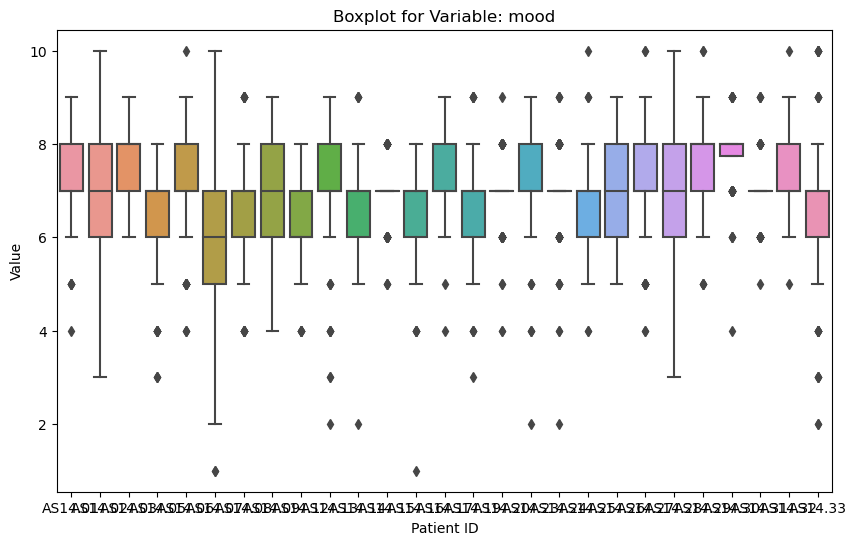

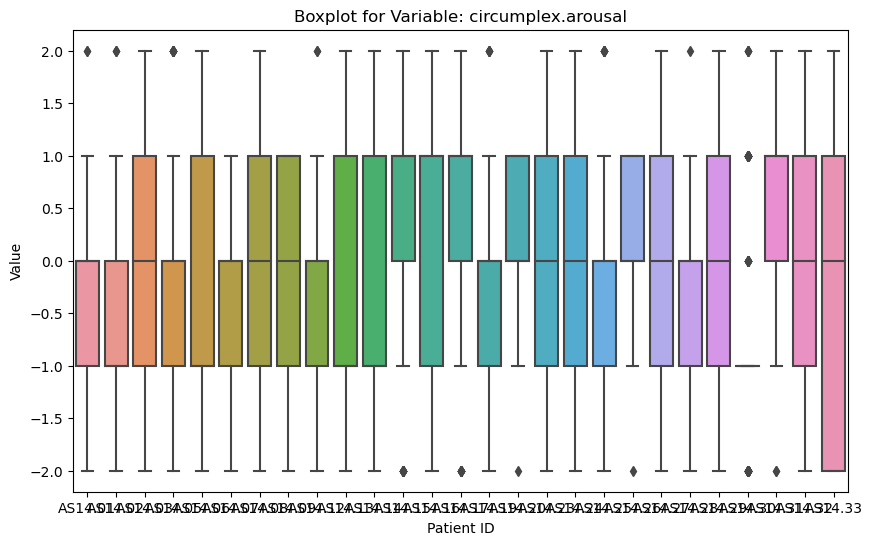

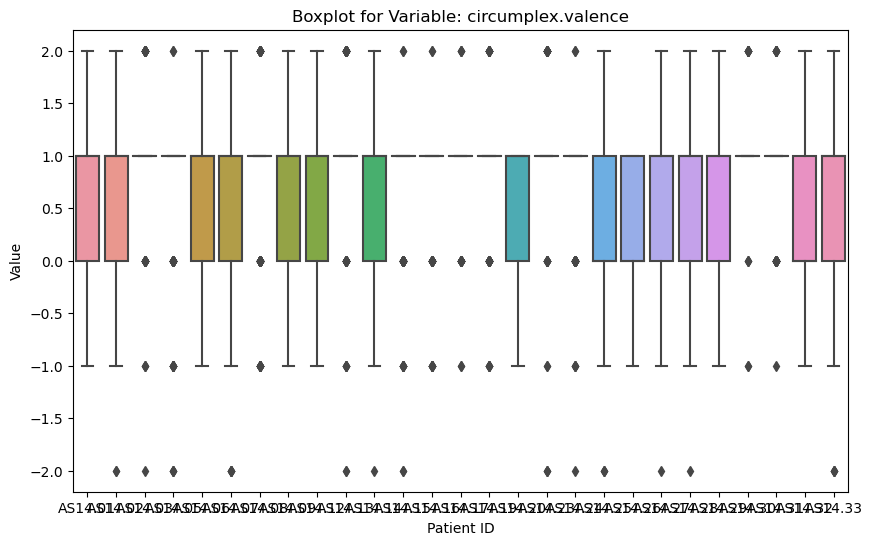

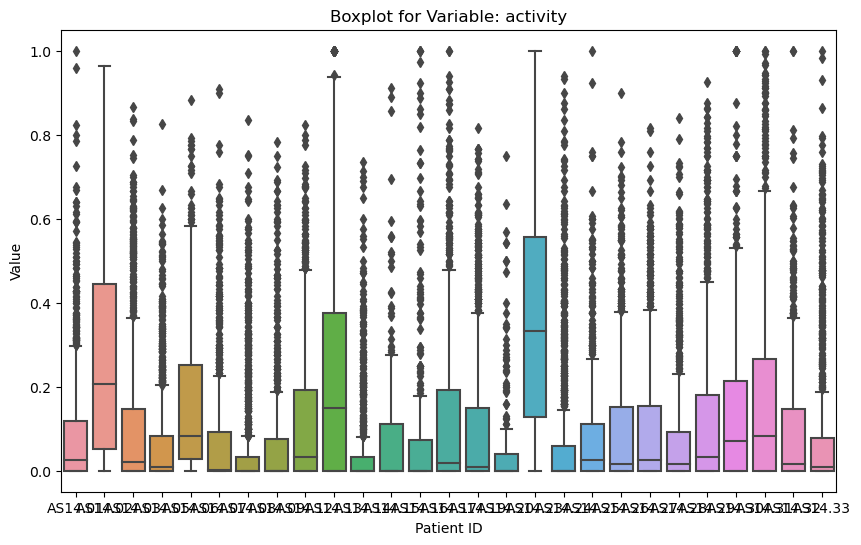

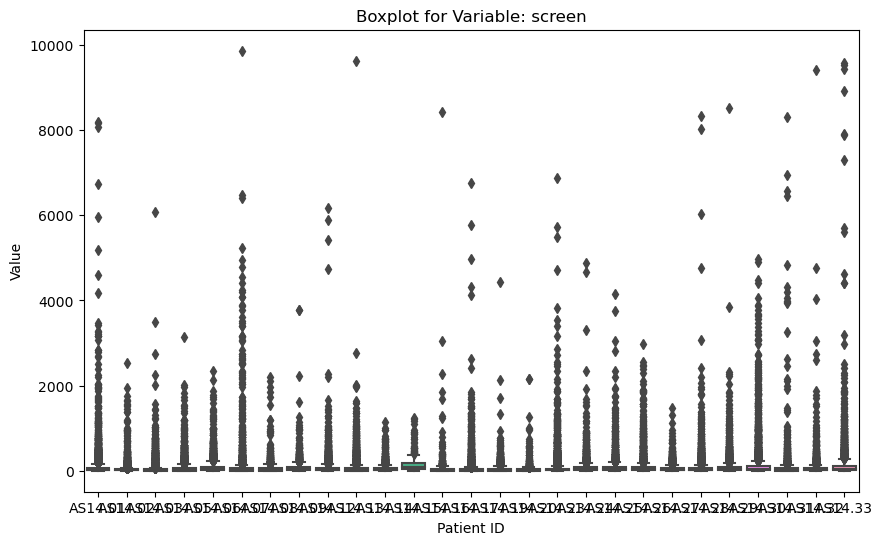

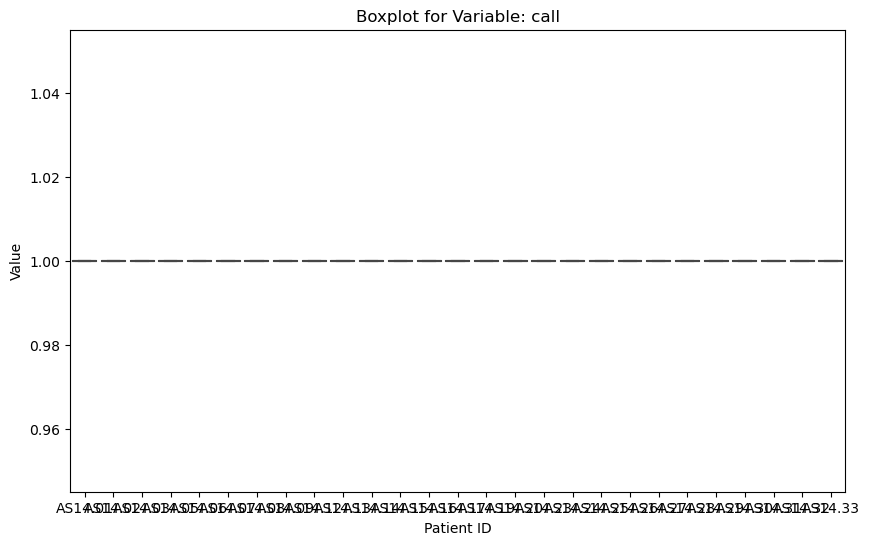

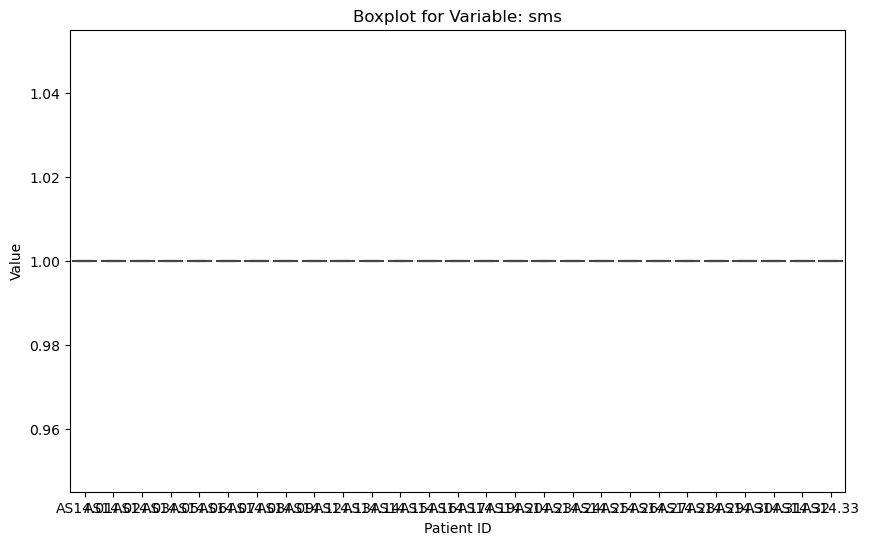

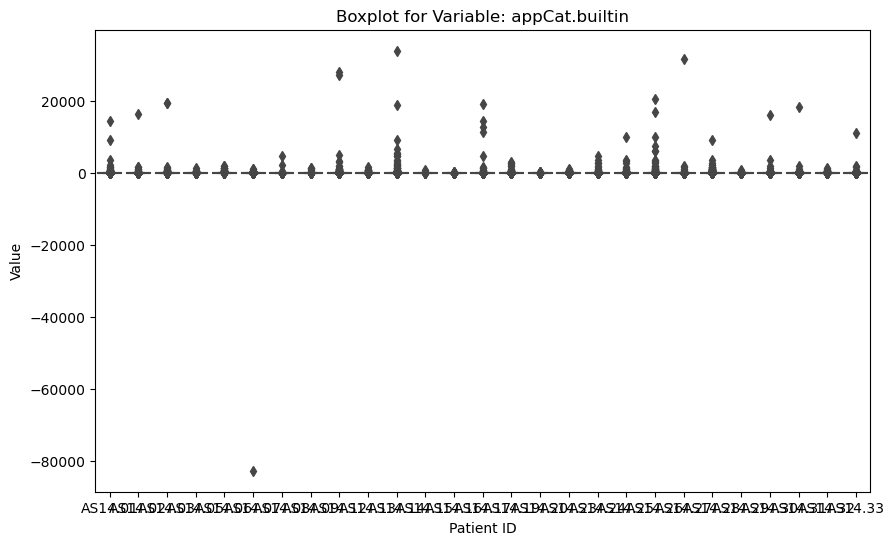

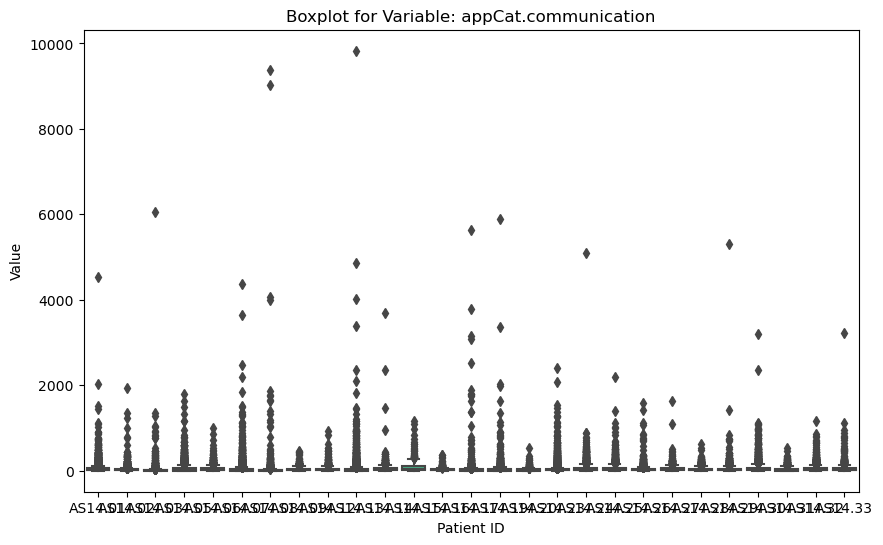

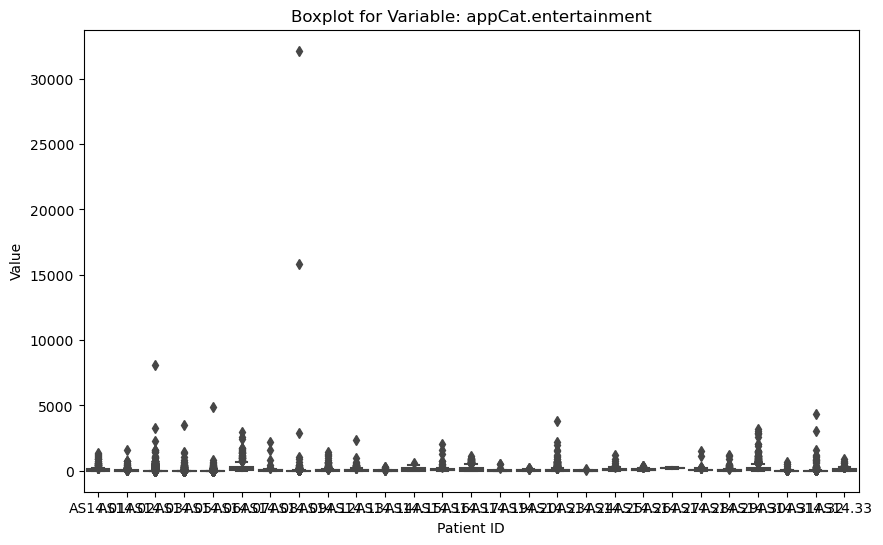

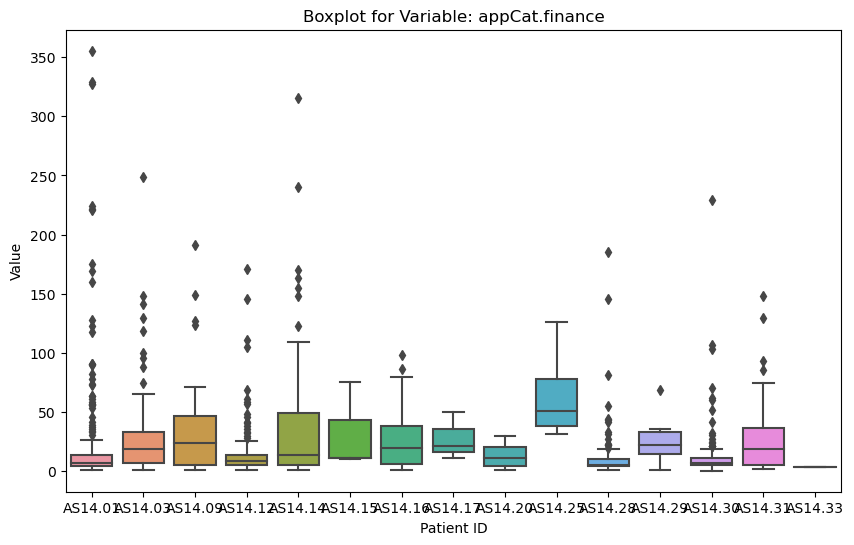

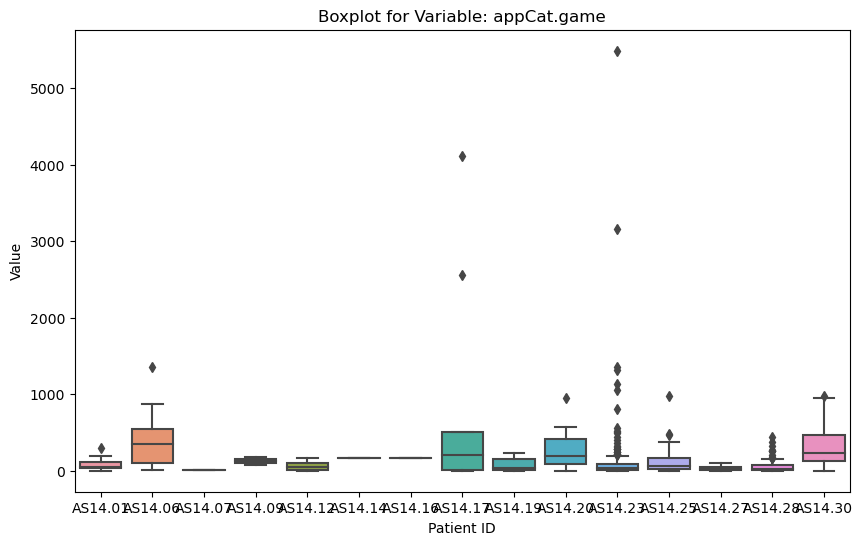

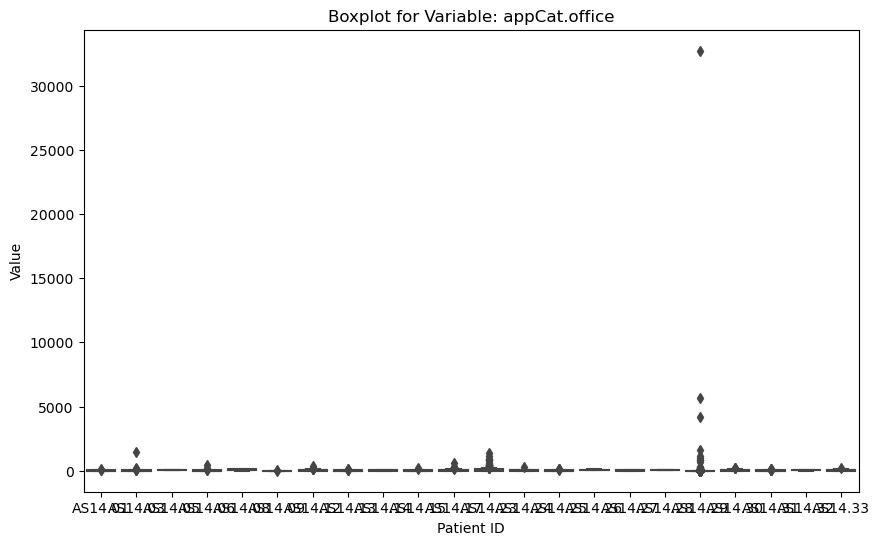

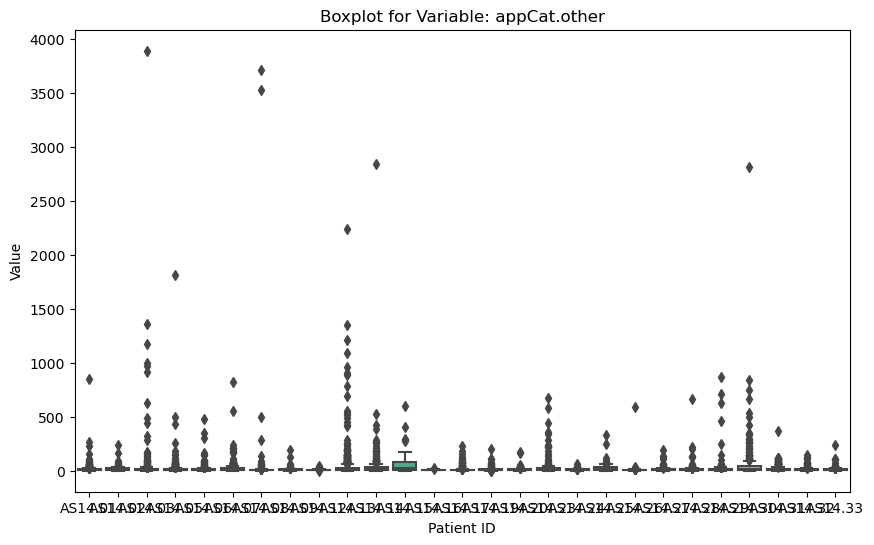

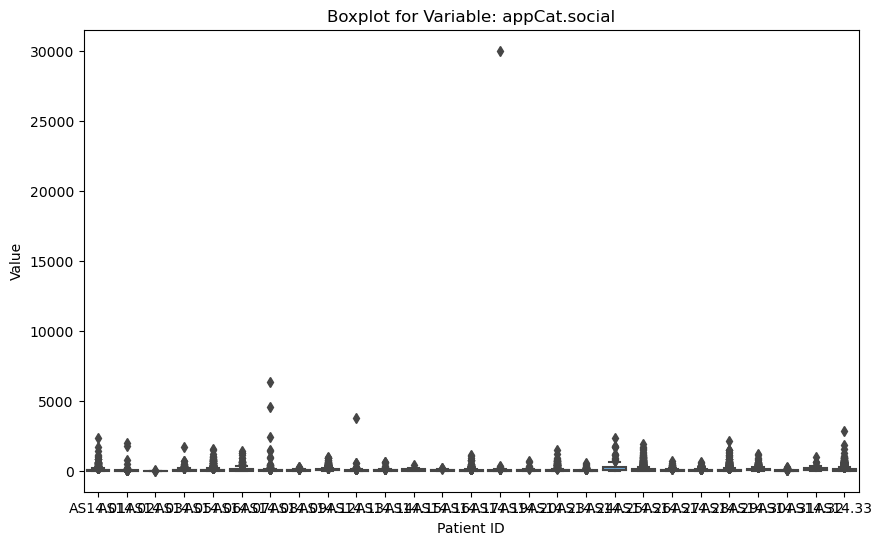

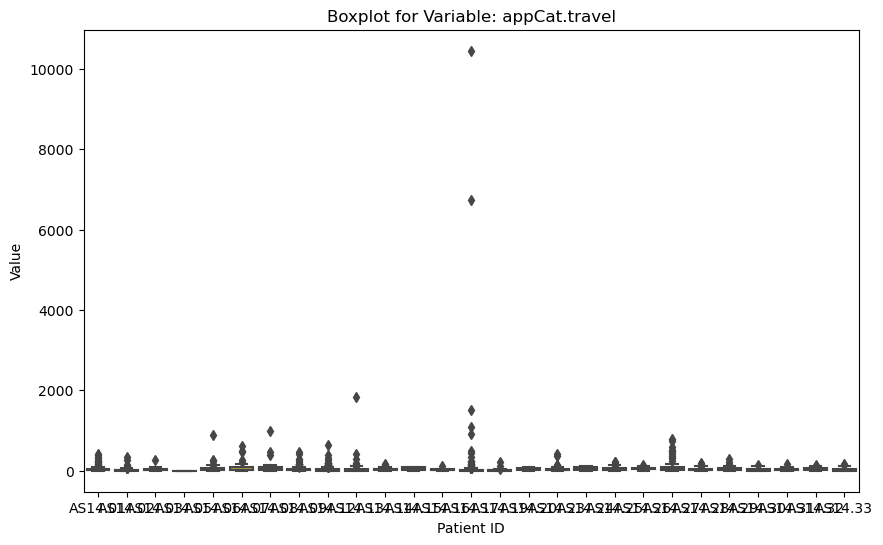

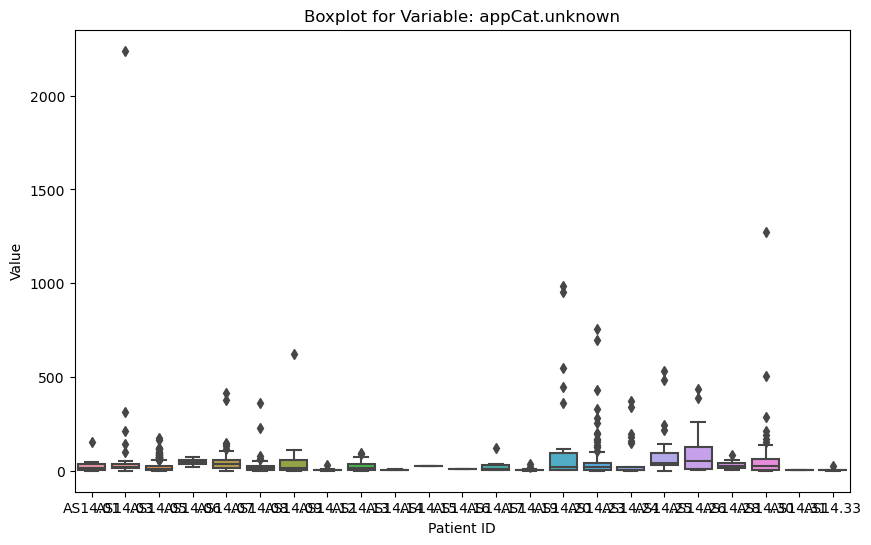

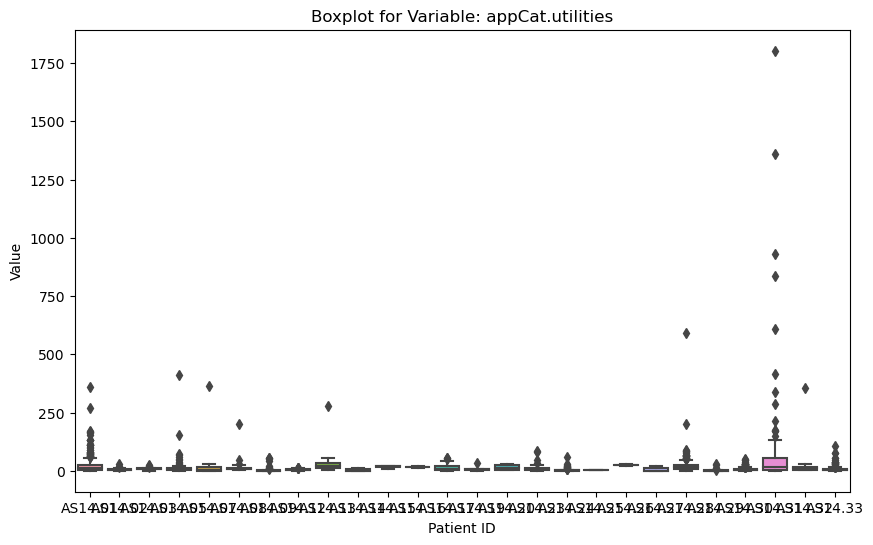

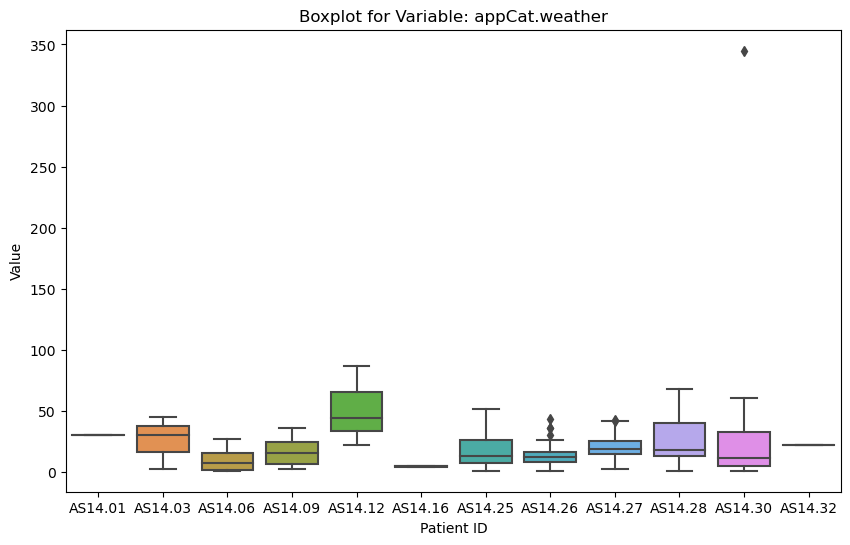

In [3]:
# read data from csv
df = pd.read_csv('dataset/dataset_mood_smartphone.csv')
# df = pd.read_csv('Assignment1/dataset/cleaned_data.csv')


variables = df['variable'].unique()

# boxplot for each attribute with all patients
for var in variables:
    plt.figure(figsize=(10, 6))

    # create a subset of the current attribute
    subset = df[df['variable'] == var]

    # plot a boxplot, where id is on the x-axis and value is on the y-axis
    sns.boxplot(x='id', y='value', data=subset, showfliers=True)

    # set the title and labels
    plt.title(f'Boxplot for Variable: {var}')
    plt.xlabel('Patient ID')
    plt.ylabel('Value')

    # show the plot
    plt.show()

#### Impute NA with 0.6*day mean + 0.4(4days mean)

In [4]:
import pandas as pd
import numpy as np

# Read the CSV file
df = pd.read_csv('dataset/dataset_mood_smartphone.csv')

# Convert the 'time' column to pandas datetime type (if not already converted)
df['time'] = pd.to_datetime(df['time'])

# Ensure the data is sorted by time
df.sort_values(by=['id', 'variable', 'time'], inplace=True)

# Function to calculate the interpolated value for a given row
def calculate_interpolated_value(row, df):
    # Only fill in when the value is NA
    if pd.isna(row['value']):
        # Calculate the daily mean (only take the data of the day)
        daily_values = df[(df['id'] == row['id']) & (df['variable'] == row['variable']) & (df['time'].dt.date == row['time'].date())]['value']
        daily_mean = daily_values.mean()

        # Values of the same time period for the adjacent four days (two days before and after, if exist)
        date_range = pd.date_range(start=row['time'].date() - pd.Timedelta(days=2), end=row['time'].date() + pd.Timedelta(days=2), freq='D').date
        date_range = date_range[date_range != row['time'].date()]  # Exclude the current day
        adjacent_values = df[(df['id'] == row['id']) & (df['variable'] == row['variable']) & (df['time'].dt.date.isin(date_range)) & (df['time'].dt.time == row['time'].time())]['value']
        adjacent_mean = adjacent_values.mean()

        # Weight calculation
        if np.isnan(daily_mean) and np.isnan(adjacent_mean):
            return np.nan  # Return NaN if both means are NaN
        elif np.isnan(daily_mean):
            return adjacent_mean  # If the daily mean is missing, only take the mean of the adjacent four days
        elif np.isnan(adjacent_mean):
            return daily_mean  # If the mean of the adjacent four days is missing, only take the daily mean
        else:
            # Fill in the NA value by combining the two means (60% daily mean and 40% mean of the adjacent four days)
            return 0.6 * daily_mean + 0.4 * adjacent_mean
    else:
        return row['value']

# Apply the function to calculate the possible interpolated value for each row
df['value'] = df.apply(lambda row: calculate_interpolated_value(row, df), axis=1)

# Save the processed DataFrame to a new CSV file
df.to_csv('processed_data.csv', index=False)

#### Clean outliers using Quartile

In [5]:
import pandas as pd

# Read the CSV file
df = pd.read_csv('processed_data.csv')

# Define a function to remove outliers within each group
def remove_outliers(group):
    Q1 = group['value'].quantile(0.25)
    Q3 = group['value'].quantile(0.75)
    IQR = Q3 - Q1
    # Define the range for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    # Only keep non-outliers
    return group[(group['value'] >= lower_bound) & (group['value'] <= upper_bound)]

# Apply the grouping and outlier removal
cleaned_df = df.groupby(['id', 'variable']).apply(remove_outliers).reset_index(drop=True)

# Save the cleaned data to a new CSV file
cleaned_df.to_csv('cleaned_data.csv', index=False)

#### Processing data to 3 time period / Calculate daily mean for each attribute of patients

**3 period per day mean**

In [9]:
# Load the data from a CSV file
file_path = 'dataset/cleaned_data.csv'
data_resample = pd.read_csv(file_path)

# Convert the 'time' to datetime format and add a new column 'hour'
data_resample['time'] = pd.to_datetime(data_resample['time'])
data_resample['hour'] = data_resample['time'].dt.hour

# Define the bins and labels for the time periods
bins = [0, 8, 16, 24]
labels = ['0-8', '8-16', '16-24']

# Create a new column 'time_period' that categorizes 'hour' into different time periods
data_resample['time_period'] = pd.cut(data_resample['hour'], bins=bins, labels=labels, right=False)

# Convert the 'time' column to datetime format again to ensure it's in the correct format
time_to_datetime(data_resample)

# Group the data by 'id', 'time', 'time_period', and 'variable', and calculate the mean of 'value'
data_grouped = data_resample.groupby(['id','time','time_period','variable'])['value'].mean().reset_index()

# Reshape the data using pivot_table so that each 'variable' becomes a column
data = data_grouped.pivot_table(index=['id', 'time','time_period'], columns='variable', values='value').reset_index()

# Ensure every day has '0-8', '8-16', '16-24' labels
data.set_index(['id', 'time', 'time_period'], inplace=True)
data = data.unstack('time_period').stack('time_period', dropna=False).reset_index()

# Save the reshaped data to a new CSV file
data.to_csv('dataset/dataset_3_period.csv', index=False)

**Daily mean**

In [7]:
import pandas as pd

# Read the CSV file
df = pd.read_csv('dataset/cleaned_data.csv', parse_dates=['time'])

# Ensure the 'time' column is of datetime type
df['time'] = pd.to_datetime(df['time'])

# Extract the date part as a new column
df['date'] = df['time'].dt.date

# Group by 'id', 'variable' and 'date', and calculate the mean for each group
grouped_df = df.groupby(['id', 'variable', 'date'])['value'].mean().reset_index()
# Round the values for 'variable' equal to 'mood'
grouped_df.loc[grouped_df['variable'] == 'mood', 'value'] = grouped_df['value'].round()

# ensure the 'date' column is of datetime type
grouped_df['date'] = pd.to_datetime(grouped_df['date'])

# Pivot the DataFrame so that each 'variable' becomes a column
pivot_df = grouped_df.pivot_table(
    index=['id', 'date'],
    columns='variable',
    values='value',
    aggfunc='first'  # if there are multiple values for the same group, take the first one
).reset_index()

# rename the columns and remove the multi-level index
pivot_df.columns.name = None  # remove the columns name
pivot_df.columns = [str(col) for col in pivot_df.columns]

# Save to a new CSV file
pivot_df.to_csv('dataset/daily_averages.csv', index=False)

In [10]:
data = pd.read_csv('dataset/daily_averages.csv')
# Define the columns to check
# columns_to_check = ['id', 'time', 'time_period','sms', 'call']
columns_to_check = ['id', 'date', 'sms', 'call']


# Create a mask where for each row, if 'id' and 'time' are not NA and either 'sms' or 'call' is not NA, the row is True
# mask = data[['id', 'time','time_period']].notna().all(axis=1) & data[['sms', 'call']].notna().any(axis=1)
mask = data[['id', 'date']].notna().all(axis=1) & data[['sms', 'call']].notna().any(axis=1)

# Invert the mask, to get rows where either 'id', 'time' are NA or both 'sms' and 'call' are NA
mask = ~mask

# Apply the mask to the dataframe
data = data[mask]

# Save the result to a new csv
data.to_csv('dataset/cleaned_data.csv', index=False)

### TASK 1C: FEATURE ENGINEERING

## TASK 2: CLASSIFICATION

In [142]:
# Now let's import the necessary libraries and create the Random Forest classifier.
import pandas as pd
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Load the dataset
file_path = 'dataset_t1b/transformed_dataset1.csv'
data = pd.read_csv(file_path)
replace_dict = {'AS14.{:02d}'.format(i): i for i in range(1, 34)}
data['id'] = data['id'].replace(replace_dict)


# Define the boundaries for binning
# bins = [0, 4, 6, 8, 10]
bins = [0, 6, 7, 10]
# Define the labels for each category
# labels = ['1-4', '5-6', '7-8', '9-10']
labels = ['1-6', '7', '8-10']

# Use pandas' cut function to categorize
data['mood(t)'] = pd.cut(data['mood(t)'], bins=bins, labels=labels, include_lowest=True)

print(data.head())

# Calculate the number of samples for each label
label_counts = data['mood(t)'].value_counts()

# Print the counts
print(label_counts)

   id  activity(t-5)  attr1(t-5)  attr2(t-5)  circumplex.arousal(t-5)  \
0   1       0.081548  2092.50622   609.60149                 0.033333   
1   1       0.046408  4356.65017  4245.48686                 0.200000   
2   1       0.153065  2665.32585   953.03515                 0.600000   
3   1       0.130540  3295.56169  1134.85600                 0.200000   
4   1       0.055485  6474.83035  2029.44045                 0.000000   

   circumplex.valence(t-5)  mood(t-5)  activity(t-4)  attr1(t-4)  attr2(t-4)  \
0                   0.8435        7.0       0.046408  4356.65017  4245.48686   
1                   0.2000        6.0       0.153065  2665.32585   953.03515   
2                   0.5000        7.0       0.130540  3295.56169  1134.85600   
3                   0.8000        7.0       0.055485  6474.83035  2029.44045   
4                   0.0000        6.0       0.052383  4648.50549  1844.45881   

   ...  attr2(t-1)  circumplex.arousal(t-1)  circumplex.valence(t-1)  \
0  ...  

### 1. Random Forest

In [24]:
# Now let's import the necessary libraries and create the Random Forest classifier.
import pandas as pd
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler

# Load the dataset
file_path = 'dataset_t1b/transformed_dataset1.csv'
data = pd.read_csv(file_path)
replace_dict = {'AS14.{:02d}'.format(i): i for i in range(1, 34)}
data['id'] = data['id'].replace(replace_dict)


# Define the boundaries for binning
# bins = [0, 4, 6, 8, 10]
bins = [0, 6, 7, 10]
# Define the labels for each category
# labels = ['1-4', '5-6', '7-8', '9-10']
labels = ['1-6', '7', '8-10']

# Use pandas' cut function to categorize
data['mood(t)'] = pd.cut(data['mood(t)'], bins=bins, labels=labels, include_lowest=True)

# print(data.head())

target = 'mood(t)'
# features = data.columns.drop(['id', 'mood(t)'])
features = data.columns.drop(['mood(t)'])


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    data[features], data[target], test_size=0.2, random_state=42)


# Define the hyperparameter grid to search
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
}


# Initialize the RandomForestClassifier
rf_classifier = RandomForestClassifier(random_state=42)
# Initialize the grid search
grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=5)

# Perform the grid search
grid_search.fit(X_train, y_train)

# Print the best parameters
print(f'Best parameters: {grid_search.best_params_}')

# Retrain the model with the best parameters
best_rf_classifier = grid_search.best_estimator_

# Predict again and calculate the accuracy
y_pred = best_rf_classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')


Best parameters: {'max_depth': 10, 'n_estimators': 100}
Accuracy: 0.7009345794392523


In [ ]:
from sklearn.metrics import roc_curve, auc
from scipy import interp
from itertools import cycle
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import LabelBinarizer

# Predict again and calculate the accuracy
y_pred = best_rf_classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

# Calculate Precision, Recall, and F1 Score
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

# For multi-class ROC-AUC
lb = LabelBinarizer()
lb.fit(y_test)
y_test_binarized = lb.transform(y_test)
y_pred_binarized = lb.transform(y_pred)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = y_test_binarized.shape[1]

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred_binarized[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_binarized.ravel(), y_pred_binarized.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

print(f'ROC-AUC Score: {roc_auc["micro"]}')



Accuracy: 0.7009345794392523
Precision: 0.7327721661054994
Recall: 0.5820113253798765
F1 Score: 0.6163718179898304
ROC-AUC Score: 0.7757009345794391


<Figure size 640x480 with 0 Axes>

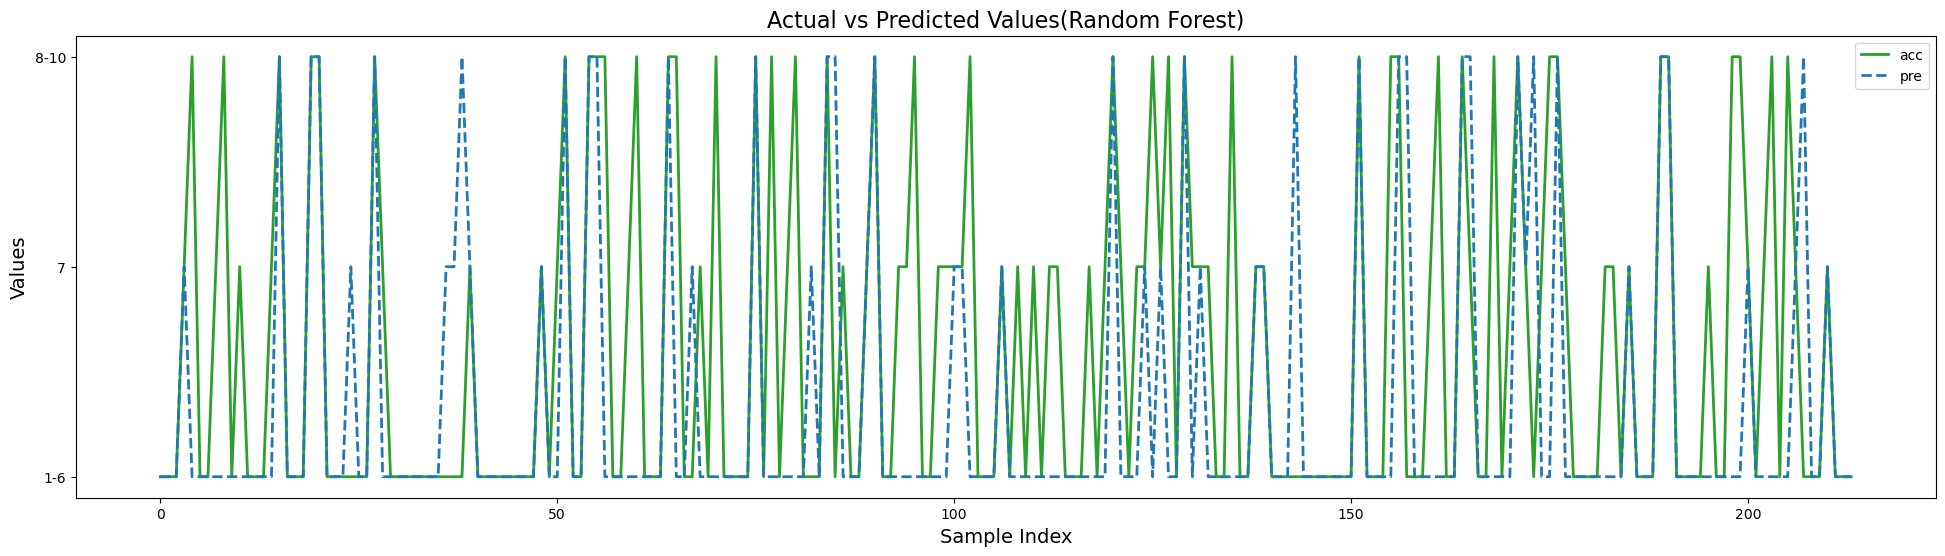

In [28]:
import matplotlib.pyplot as plt
import numpy as np

rf_y_pred = best_rf_classifier.predict(X_test)

# Convert to numpy array to ensure compatibility with matplotlib if they are not already
y_test = np.array(y_test).flatten()
rf_y_pred = np.array(rf_y_pred).flatten()

# Clear any previous plots
plt.clf()

# Set the figure size to a more appropriate aspect ratio
plt.figure(figsize=(24, 6))

# Choose more aesthetically pleasing colors
actual_color = "#2ca02c"  # A nice shade of green
predicted_color = "#1f77b4"  # A pleasant shade of blue

# Plot actual values ('acc') with the chosen green color
plt.plot(y_test, color=actual_color, label='acc', linewidth=2)

# Plot predicted values ('pre') with the chosen blue color
plt.plot(rf_y_pred, color=predicted_color, label='pre', linestyle='--', linewidth=2)

# Set the title and labels with the appropriate font size
plt.title('Actual vs Predicted Values(Random Forest)', fontsize=16)
plt.xlabel('Sample Index', fontsize=14)
plt.ylabel('Values', fontsize=14)

# Set custom y-axis ticks and labels
plt.yticks([0,1,2], ['1-6', '7', '8-10'])

# Show the legend to differentiate between actual ('acc') and predicted ('pre') lines
plt.legend()

# Finally, display the plot
plt.show()


### 2. RNN

#### LSTM

In [36]:
# LSTM Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from keras_tuner import RandomSearch, HyperParameters
from tensorflow.keras.utils import to_categorical
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder

# Load the dataset
file_path = 'dataset_t1b/transformed_dataset1.csv'
df = pd.read_csv(file_path)
replace_dict = {'AS14.{:02d}'.format(i): i for i in range(1, 34)}
df['id'] = df['id'].replace(replace_dict)

# Bin, categorize, clean data as before
bins = [0, 6, 7, 10]
labels = ['1-6', '7', '8-10']
df['mood(t)'] = pd.cut(df['mood(t)'], bins=bins, labels=labels, include_lowest=True)
df['mood(t)'] = df['mood(t)'].astype('category')
# 遍历所有相关的列
# for i in range(-5, 1):  # 这里的范围根据你的情绪数据的时间跨度调整，从t-5到t
#     column_name = f'mood(t{i})' if i != 0 else 'mood(t)'  # 当i=0时，列名是'mood(t)'
#     df[column_name] = pd.cut(df[column_name], bins=bins, labels=labels, include_lowest=True)
# df['mood(t)'] = df['mood(t)'].astype('category')


df = df.dropna()
feature_columns = df.columns.difference(['mood(t)'])
df[feature_columns] = df[feature_columns].astype(float)
mood_codes = df['mood(t)'].cat.codes
X = df[feature_columns].values
y = to_categorical(mood_codes, num_classes=df['mood(t)'].nunique())

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize the data
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [16]:
# LSTM Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from keras_tuner import RandomSearch, HyperParameters
from tensorflow.keras.utils import to_categorical
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder

# Load the dataset
file_path = 'dataset_t1b/transformed_dataset1.csv'
df = pd.read_csv(file_path)
replace_dict = {'AS14.{:02d}'.format(i): i for i in range(1, 34)}
df['id'] = df['id'].replace(replace_dict)

# Bin, categorize, clean data as before
bins = [0, 6, 7, 10]
labels = ['1-6', '7', '8-10']
df['mood(t)'] = pd.cut(df['mood(t)'], bins=bins, labels=labels, include_lowest=True)
df['mood(t)'] = df['mood(t)'].astype('category')
# 遍历所有相关的列
# for i in range(-5, 1):  # 这里的范围根据你的情绪数据的时间跨度调整，从t-5到t
#     column_name = f'mood(t{i})' if i != 0 else 'mood(t)'  # 当i=0时，列名是'mood(t)'
#     df[column_name] = pd.cut(df[column_name], bins=bins, labels=labels, include_lowest=True)
# df['mood(t)'] = df['mood(t)'].astype('category')


df = df.dropna()
feature_columns = df.columns.difference(['mood(t)'])
df[feature_columns] = df[feature_columns].astype(float)
mood_codes = df['mood(t)'].cat.codes
X = df[feature_columns].values
y = to_categorical(mood_codes, num_classes=df['mood(t)'].nunique())

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize the data
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


# Define the model building function including hyperparameters
def build_model(hp):
    model = Sequential()
    model.add(Dense(units=hp.Int('units', min_value=32, max_value=512, step=32),
                    activation="relu", input_dim=X_train.shape[1]))
    model.add(Dropout(rate=hp.Float('dropout', min_value=0.1, max_value=0.5, step=0.1)))
    model.add(Dense(units=hp.Int('units', min_value=32, max_value=512, step=32),
                    activation="relu"))
    model.add(Dropout(rate=hp.Float('dropout', min_value=0.1, max_value=0.5, step=0.1)))
    model.add(Dense(units=hp.Int('units', min_value=32, max_value=512, step=32),
                    activation="relu"))
    model.add(Dropout(rate=hp.Float('dropout', min_value=0.1, max_value=0.5, step=0.1)))
    model.add(Dense(y_train.shape[1], activation='softmax'))
    model.compile(optimizer=Adam(hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Initialize HyperParameters and Tuner
hp = HyperParameters()
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1,
    directory='my_dir',
    project_name='keras_tuner_demo',
    hyperparameters=hp,
    overwrite=True  # Add this to overwrite the previous project files
)

# Add batch size as a hyperparameter in the search space
tuner.oracle.hyperparameters.Choice('batch_size', values=[16, 32, 64, 128, 256])

# Start the search process
tuner.search(X_train, y_train,
             epochs=50,
             validation_split=0.2,
             callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)])

# Retrieve the best model
best_model = tuner.get_best_models(num_models=1)[0]
best_model.summary()

# Results and evaluation
tuner.results_summary()
best_hps = tuner.get_best_hyperparameters()[0]
print("Best hyperparameters:", best_hps.values)

train_loss, train_acc = best_model.evaluate(X_train, y_train, verbose=0)
test_loss, test_acc = best_model.evaluate(X_test, y_test, verbose=0)

print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))


Trial 10 Complete [00h 00m 13s]
val_accuracy: 0.6918604373931885

Best val_accuracy So Far: 0.6976743936538696
Total elapsed time: 00h 02m 53s
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 224)               8288      
_________________________________________________________________
dropout (Dropout)            (None, 224)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 224)               50400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 224)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 224)               50400     
_________________________________________________________________
dropout_2 (Dropout)          (None, 224)     

2024-04-21 14:37:16.590573: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Train: 0.724, Test: 0.766


In [17]:
# Save the model
best_model.save('my_model.h5')

In [ ]:
history = best_model.fit(X_train, y_train, validation_split=0.3, epochs=50, callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)])
# history = best_model.fit(X_train, Y_train, validation_split=0.2, epochs=50, batch_size=32)

Accuracy: 0.766
Precision: 0.830
Recall: 0.653
F1 Score: 0.701
ROC-AUC: 0.886


2024-04-21 14:54:00.888309: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


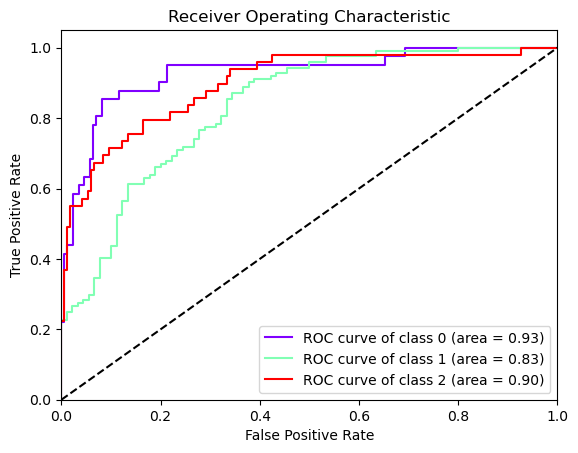

In [37]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import classification_report, roc_curve, auc
import matplotlib.pyplot as plt

# Assuming y_test and y_pred are available from the previous code setup
# We need the predictions for calculating the metrics
y_pred = best_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# Calculate the various metrics
accuracy = accuracy_score(y_test_classes, y_pred_classes)
precision = precision_score(y_test_classes, y_pred_classes, average='macro')
recall = recall_score(y_test_classes, y_pred_classes, average='macro')
f1 = f1_score(y_test_classes, y_pred_classes, average='macro')
roc_auc = roc_auc_score(y_test, y_pred, multi_class='ovo')

# Print the metrics
print(f'Accuracy: {accuracy:.3f}')
print(f'Precision: {precision:.3f}')
print(f'Recall: {recall:.3f}')
print(f'F1 Score: {f1:.3f}')
print(f'ROC-AUC: {roc_auc:.3f}')

# ROC Curve for each class
fpr = dict()
tpr = dict()
roc_auc_dict = dict()
n_classes = y_test.shape[1]
colors = iter(plt.cm.rainbow(np.linspace(0, 1, n_classes)))

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc_dict[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], color=next(colors), label=f'ROC curve of class {i} (area = {roc_auc_dict[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


2024-04-21 16:15:24.832602: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


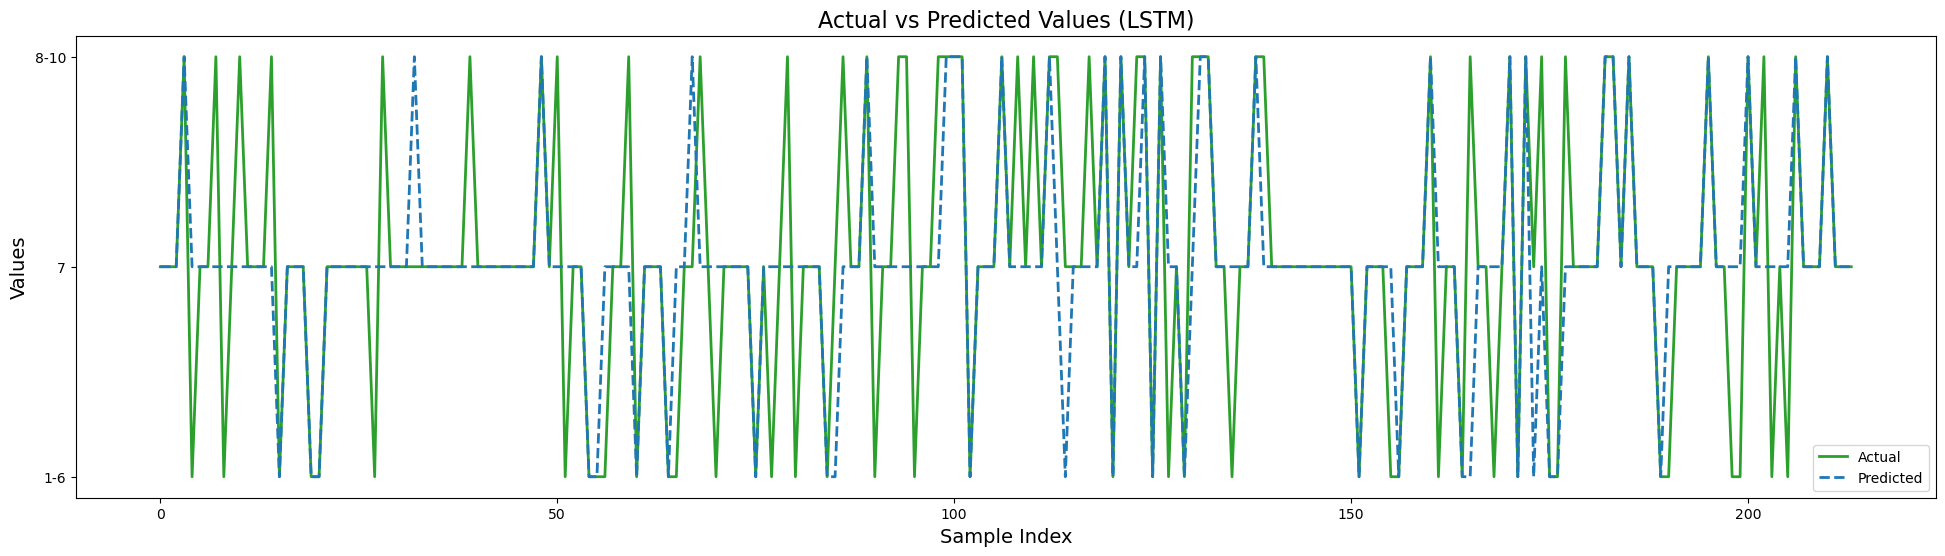

In [53]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.models import load_model

# Load your best LSTM model
best_model = load_model('my_model.h5')

# Predict using the LSTM model
lstm_y_pred = best_model.predict(X_test)

# Convert softmax probabilities to class labels
y_test_labels = np.argmax(y_test, axis=1)
lstm_y_pred_labels = np.argmax(lstm_y_pred, axis=1)

# Plotting
plt.figure(figsize=(24, 6))
plt.plot(y_test_labels, color="#2ca02c", label='Actual', linewidth=2)
plt.plot(lstm_y_pred_labels, color="#1f77b4", label='Predicted', linestyle='--', linewidth=2)
plt.title('Actual vs Predicted Values (LSTM)', fontsize=16)
plt.xlabel('Sample Index', fontsize=14)
plt.ylabel('Values', fontsize=14)

unique_values = np.sort(np.unique(y_test_labels))

# Now create a mapping for your categorical bins to these unique values
# This is just an example based on the assumption of 3 unique values corresponding to your labels
# You will need to adjust the values based on what unique_values actually contains
category_labels = {unique_value: label for unique_value, label in zip(unique_values, ['1-6', '7', '8-10'])}

# Set the correct yticks using the mapping
plt.yticks(ticks=list(category_labels.keys()), labels=list(category_labels.values()))

plt.legend()
plt.show()

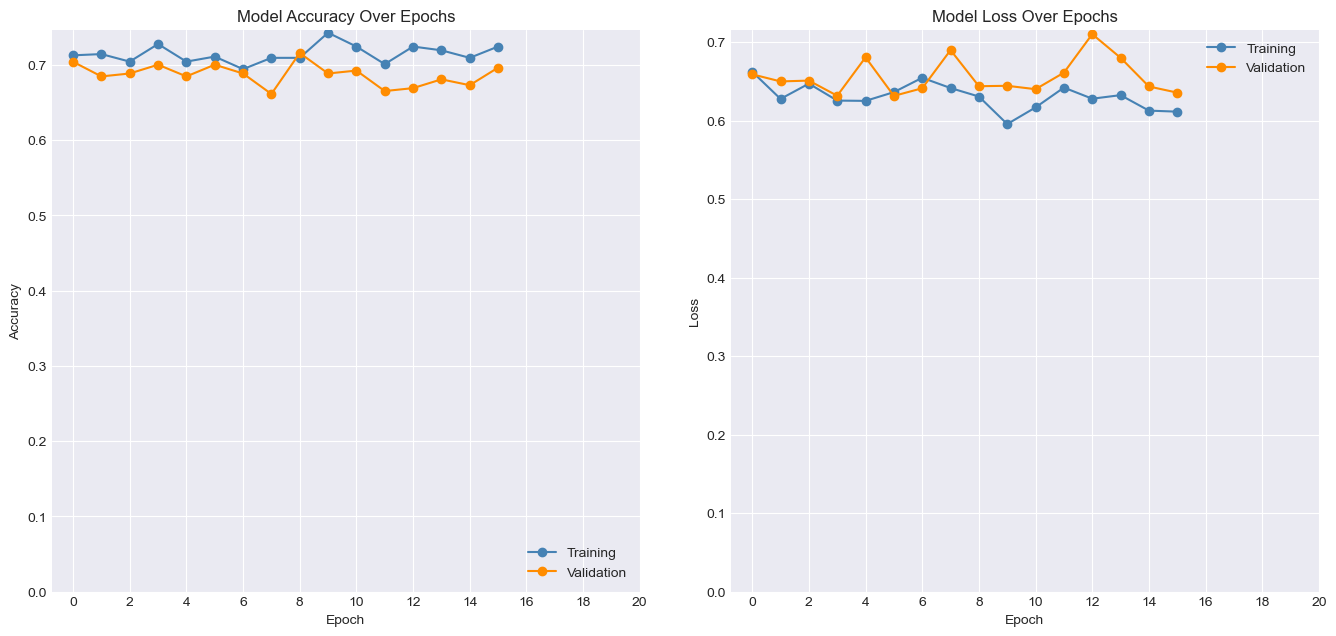

In [172]:
import matplotlib.pyplot as plt


# Define a style for the plots (you can also use plt.style.use('ggplot') for a ggplot-like style)
plt.style.use('seaborn-darkgrid')

# Plot training & validation accuracy values
plt.figure(figsize=(14, 7))  # Increase the overall size of the plot

# Accuracy subplot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], marker='o', linestyle='-', color='steelblue')
plt.plot(history.history['val_accuracy'], marker='o', linestyle='-', color='darkorange')
plt.title('Model Accuracy Over Epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.xticks(range(0, 21, 2))  # Adjust x-axis ticks
plt.ylim(0)  # Start y-axis at 0
plt.legend(['Training', 'Validation'], loc='lower right')

# Loss subplot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], marker='o', linestyle='-', color='steelblue')
plt.plot(history.history['val_loss'], marker='o', linestyle='-', color='darkorange')
plt.title('Model Loss Over Epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.xticks(range(0, 21, 2))  # Adjust x-axis ticks
plt.ylim(0)  # Start y-axis at 0
plt.legend(['Training', 'Validation'], loc='upper right')

plt.tight_layout(pad=3.0)
plt.show()


### 3. Benchmark(NB Classification)

In [121]:
print(f'Number of samples in X_train: {len(X_train)}')
print(f'Number of samples in y_train: {len(Y_train)}')

Number of samples in X_train: 749
Number of samples in y_train: 749


In [181]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
import pandas as pd
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Load the dataset
file_path = 'dataset_t1b/transformed_dataset1.csv'
data = pd.read_csv(file_path)
replace_dict = {'AS14.{:02d}'.format(i): i for i in range(1, 34)}
data['id'] = data['id'].replace(replace_dict)


# # Define the boundaries for binning
# bins = [0, 4, 6, 8, 10]
# # Define the labels for each category
# labels = ['1-4', '5-6', '7-8', '9-10']
bins = [0, 6, 7, 10]
labels = ['1-6', '7', '8-10']
# Use pandas' cut function to categorize
data['mood(t)'] = pd.cut(data['mood(t)'], bins=bins, labels=labels, include_lowest=True)

target = 'mood(t)'
# features = data.columns.drop(['id', 'mood(t)'])
features = data.columns.drop(['mood(t)'])


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    data[features], data[target], test_size=0.2, random_state=42)
# Create a Gaussian Naive Bayes classifier
clf = GaussianNB()

# Fit the classifier with the training data
clf.fit(X_train, y_train.ravel())
# Predict the labels of the test set
y_pred = clf.predict(X_test)

# Calculate the accuracy of the classifier
accuracy = accuracy_score(y_test, y_pred)

print(f'Accuracy of Naive Bayes classifier: {accuracy * 100:.2f}%')

from sklearn.metrics import roc_curve, auc
from scipy import interp
from itertools import cycle
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import LabelBinarizer

# Predict again and calculate the accuracy
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

# Calculate Precision, Recall, and F1 Score
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

# For multi-class ROC-AUC
lb = LabelBinarizer()
lb.fit(y_test)
y_test_binarized = lb.transform(y_test)
y_pred_binarized = lb.transform(y_pred)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = y_test_binarized.shape[1]

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred_binarized[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_binarized.ravel(), y_pred_binarized.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

print(f'ROC-AUC Score: {roc_auc["micro"]}')


Accuracy of Naive Bayes classifier: 64.95%
Accuracy: 0.6495327102803738
Precision: 0.608374874851263
Recall: 0.611240011346789
F1 Score: 0.6084140345600447
ROC-AUC Score: 0.7371495327102804


## TASK 4 NUMERICAL PREDICTION

In [43]:
print(f'Length of X: {len(X)}')
print(f'Length of y: {len(Y)}')

Length of X: 1307
Length of y: 1307


In [187]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.tree import DecisionTreeRegressor


# Load the dataset
file_path = 'dataset_t1b/transformed_dataset1.csv'
data = pd.read_csv(file_path)
replace_dict = {'AS14.{:02d}'.format(i): i for i in range(1, 34)}
data['id'] = data['id'].replace(replace_dict)


target = 'mood(t)'
# features = data.columns.drop(['id', 'mood(t)'])
features = data.columns.drop(['mood(t)'])


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    data[features], data[target], test_size=0.2, random_state=42)

print(X_train.head())
# Normalize the data
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)
lr_predictions = lr.predict(X_test)
lr_mse = mean_squared_error(y_test, lr_predictions)
lr_mae = mean_absolute_error(y_test, lr_predictions)
print(f'Linear Regression MSE: {lr_mse}')
print(f'Linear Regression MAE: {lr_mae}')

# Random Forest Regression
rf = RandomForestRegressor()
rf.fit(X_train, y_train)
rf_predictions = rf.predict(X_test)
rf_mse = mean_squared_error(y_test, rf_predictions)
rf_mae = mean_absolute_error(y_test, rf_predictions)
print(f'Random Forest Regression MSE: {rf_mse}')
print(f'Random Forest Regression MAE: {rf_mae}')

     id  activity(t-5)  attr1(t-5)  attr2(t-5)  circumplex.arousal(t-5)  \
351  12       0.130629  1647.96297  2913.24035                 0.000000   
530  16       0.023611  1377.42245   258.52271                 0.750000   
896  29       0.065292  2270.01795  2395.11767                -0.800000   
947  30       0.170820  6451.36874  1834.46785                -0.963167   
936  30       0.125173  5179.66449  2741.78205                -1.000000   

     circumplex.valence(t-5)  mood(t-5)  activity(t-4)  attr1(t-4)  \
351                      1.0        7.0       0.050169  1782.44278   
530                      1.0        7.0       0.013731  1001.26399   
896                      1.0        8.0       0.125358  3537.26781   
947                      1.0        8.0       0.122327  7891.36800   
936                      1.0        8.0       0.115006  8127.51835   

     attr2(t-4)  ...  attr1(t-1)  attr2(t-1)  circumplex.arousal(t-1)  \
351  3358.51306  ...  2084.27700  4647.73841           

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler

import pandas as pd

# Load the dataset
file_path = 'dataset_t1b/transformed_dataset1.csv'
data = pd.read_csv(file_path)
replace_dict = {'AS14.{:02d}'.format(i): i for i in range(1, 34)}
data['id'] = data['id'].replace(replace_dict)

target = 'mood(t)'
features = data.columns.drop(['mood(t)'])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    data[features], data[target], test_size=0.2, random_state=42)

# # Normalize the data
# scaler = MinMaxScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

# Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)
lr_predictions = lr.predict(X_test)
lr_mse = mean_squared_error(y_test, lr_predictions)
lr_mae = mean_absolute_error(y_test, lr_predictions)
print(f'Linear Regression MSE: {lr_mse}')
print(f'Linear Regression MAE: {lr_mae}')

# Random Forest Regression with Hyperparameter Optimization
rf = RandomForestRegressor(random_state=42)
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)
best_rf = grid_search.best_estimator_

rf_predictions = best_rf.predict(X_test)
rf_mse = mean_squared_error(y_test, rf_predictions)
rf_mae = mean_absolute_error(y_test, rf_predictions)
print(f'Random Forest Regression MSE: {rf_mse}')
print(f'Random Forest Regression MAE: {rf_mae}')
print(f'Best Random Forest Parameters: {grid_search.best_params_}')


In [54]:
def create_latex_table(data):
    latex_table = "\\begin{table}[h]\n\\centering\n\\begin{tabular}{ll}\n\\hline\n"
    latex_table += "Feature & Importance \\\\ \\hline\n"
    for feature, importance in data:
        latex_table += f"{feature} & {importance} \\\\ \n"
    latex_table += "\\hline\n\\end{tabular}\n\\caption{Feature Importances}\n\\label{table:feature-importances}\n\\end{table}"
    return latex_table

# Continue the previous code to get the data and create a LaTeX table
df = pd.DataFrame(data, columns=['Feature', 'Importance'])

# Convert the DataFrame to a LaTeX table format
latex_table = create_latex_table(df.values)
print(latex_table)

\begin{table}[h]
\centering
\begin{tabular}{ll}
\hline
Feature & Importance \\ \hline
nan & nan \\ 
nan & nan \\ 
nan & nan \\ 
nan & nan \\ 
nan & nan \\ 
nan & nan \\ 
nan & nan \\ 
nan & nan \\ 
nan & nan \\ 
nan & nan \\ 
nan & nan \\ 
nan & nan \\ 
nan & nan \\ 
nan & nan \\ 
nan & nan \\ 
nan & nan \\ 
nan & nan \\ 
nan & nan \\ 
nan & nan \\ 
nan & nan \\ 
nan & nan \\ 
nan & nan \\ 
nan & nan \\ 
nan & nan \\ 
nan & nan \\ 
nan & nan \\ 
nan & nan \\ 
nan & nan \\ 
nan & nan \\ 
nan & nan \\ 
nan & nan \\ 
nan & nan \\ 
nan & nan \\ 
nan & nan \\ 
nan & nan \\ 
nan & nan \\ 
nan & nan \\ 
nan & nan \\ 
nan & nan \\ 
nan & nan \\ 
nan & nan \\ 
nan & nan \\ 
nan & nan \\ 
nan & nan \\ 
nan & nan \\ 
nan & nan \\ 
nan & nan \\ 
nan & nan \\ 
nan & nan \\ 
nan & nan \\ 
nan & nan \\ 
nan & nan \\ 
nan & nan \\ 
nan & nan \\ 
nan & nan \\ 
nan & nan \\ 
nan & nan \\ 
nan & nan \\ 
nan & nan \\ 
nan & nan \\ 
nan & nan \\ 
nan & nan \\ 
nan & nan \\ 
nan & nan \\ 
nan & nan \\ 
nan 